# Assignment 2: Word Prediction

**Deadline**: Sunday, April 18th, by 9pm.

**Submission**: Submit a PDF export of the completed notebook as well as the ipynb file. 

 

In this assignment, we will make a neural network that can predict the next word
in a sentence given the previous three.  
In doing this prediction task, our neural networks will learn about *words* and about
how to represent words. We'll explore the *vector representations* of words that our
model produces, and analyze these representations.

You may modify the starter code as you see fit, including changing the signatures of functions and adding/removing helper functions. However, please make sure that you properly explain what you are doing and why.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections

import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
np.random.seed(0)



## Question 1. Data (18%)

With any machine learning problem, the first thing that we would want to do
is to get an intuitive understanding of what our data looks like. Download the file
`raw_sentences.txt` from the course page on Moodle and upload it to Google Drive.
Then, mount Google Drive from your Google Colab notebook:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Find the path to `raw_sentences.txt`:

In [ ]:
file_path = '/content/gdrive/My Drive/raw_sentences.txt' # TODO - UPDATE ME!

The following code reads the sentences in our file, split each sentence into
its individual words, and stores the sentences (list of words) in the
variable `sentences`.

In [ ]:
sentences = []
for line in open(file_path):
    words = line.split()
    sentence = [word.lower() for word in words]
    sentences.append(sentence)

There are 97,162 sentences in total, and 
these sentences are composed of 250 distinct words.

In [ ]:
vocab = set([w for s in sentences for w in s])
print(len(sentences)) # 97162
print(len(vocab)) # 250

97162
250


We'll separate our data into training, validation, and test.
We'll use `10,000 sentences for test, 10,000 for validation, and
the rest for training.

In [ ]:
test, valid, train = sentences[:10000], sentences[10000:20000], sentences[20000:]

### Part (a) -- 3%

**Display** 10 sentences in the training set.
**Explain** how punctuations are treated in our word representation, and how words
with apostrophes are represented.

In [ ]:
for i,sent in enumerate(train[12:22]):
  print(str(i+1)+".", " " + str(sent))


1.  ['it', "'s", 'part', 'of', 'this', 'game', ',', 'man', '.']
2.  ['it', 'was', ':', 'how', 'do', 'we', 'get', 'there', '?']
3.  ['but', 'they', 'do', 'nt', 'last', 'too', 'long', '.']
4.  ['more', 'are', 'like', 'me', ',', 'she', 'said', '.']
5.  ['who', 'do', 'you', 'think', 'they', 'want', 'to', 'be', 'like', '?']
6.  ['no', ',', 'he', 'could', 'not', '.']
7.  ['so', 'i', 'left', 'it', 'up', 'to', 'them', '.']
8.  ['we', 'were', 'nt', 'right', '.']
9.  ['we', 'are', 'a', 'good', 'team', '.']
10.  ['i', 'did', 'nt', 'know', 'about', 'it', ',', 'she', 'said', '.']


**Write your answers here:**
We can tell that punctuations such as dot, comma, or question marks are treated as a word. When looking at sentence number 1 for example, we observe that words with apostrophes are represented as 2 different words: the first is the prefix of the word and the second is the rest of the word starting from the apostrophes.

### Part (b) -- 4%

**Print** the 10 most common words in the vocabulary and how often does each of these
words appear in the training sentences. Express the second quantity as a percentage
(i.e. number of occurences of the  word / total number of words in the training set).

These are useful quantities to compute, because one of the first things a machine learning model will learn is to predict the **most common** class. Getting a sense of the
distribution of our data will help you understand our model's behaviour.

You can use Python's `collections.Counter` class if you would like to.

   Word  Count  Percentile
0     .  64297   10.695720
1    it  23118    3.845648
2     ,  19537    3.249954
3     i  17684    2.941710
4    do  16181    2.691688
5    to  15490    2.576741
6    nt  13009    2.164030
7     ?  12881    2.142737
8   the  12583    2.093165
9  that  12535    2.085180


Text(0.5, 1.0, '10 Most Common Words Count')

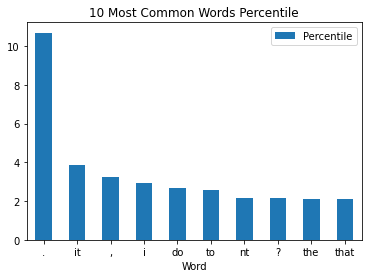

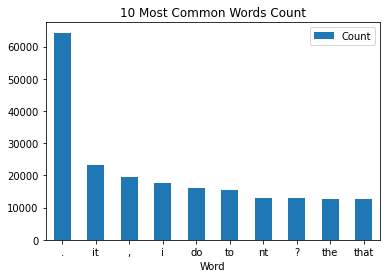

In [ ]:
# Merge all the words to a single sentence
full_list = []
for i in sentences:
  full_list += i
# Count how many appearences there are for each word in the vocabulary using Counter
c = collections.Counter(full_list)
# Extract the 10 most common words
mos_common_word = c.most_common(10)
mos_common_word = [i[0] for i in mos_common_word]

# Extract all the words in a single sentence in the training set
full_train_list = []
for i in train:
  full_train_list += i
# Count how many appearences there are for each word using Counter
c = collections.Counter(full_train_list)

# Get the frequency percentile in the training set
train_freq_dict = []
for word in mos_common_word:
  train_freq_dict.append((word,c[word]))
df=pd.DataFrame(train_freq_dict,columns=['Word','Count'])
df['Percentile']=(df['Count']/len(full_train_list))*100
print(df.head(10))
# Print the 10 most common word percentile
ax=df.plot.bar(x='Word', y='Percentile', rot=0)
ax.set_title("10 Most Common Words Percentile")
# Print the 10 most common word Count
ax=df.plot.bar(x='Word', y='Count', rot=0)
ax.set_title("10 Most Common Words Count")


### Part (c) -- 11%

Our neural network will take as input three words and predict the next one. Therefore, we need our data set to be comprised of seuqnces of four consecutive words in a sentence, referred to as *4grams*. 

**Complete** the helper functions `convert_words_to_indices` and
`generate_4grams`, so that the function `process_data` will take a 
list of sentences (i.e. list of list of words), and generate an 
$N \times 4$ numpy matrix containing indices of 4 words that appear
next to each other, where $N$ is the number of 4grams (sequences of 4 words appearing one after the other) that can be found in the complete list of sentences. Examples of how these functions should operate are detailed in the code below. 

You can use the defined `vocab`, `vocab_itos`,
and `vocab_stoi` in your code.

In [ ]:
# A list of all the words in the data set. We will assign a unique 
# identifier for each of these words.
vocab = sorted(list(set([w for s in train for w in s])))
# A mapping of index => word (string)
vocab_itos = dict(enumerate(vocab))
# A mapping of word => its index
vocab_stoi = {word:index for index, word in vocab_itos.items()}

def convert_words_to_indices(sents):
    """
    This function takes a list of sentences (list of list of words)
    and returns a new list with the same structure, but where each word
    is replaced by its index in `vocab_stoi`.

    Example:
    >>> convert_words_to_indices([['one', 'in', 'five', 'are', 'over', 'here'], ['other', 'one', 'since', 'yesterday'], ['you']])
    [[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]]
    """

    # Write your code here
    indices_list = []
    for sent in sents:
      temp_list = []
      for word in sent:
        temp_list.append(vocab_stoi[word])
      indices_list.append(temp_list)
    return indices_list


def generate_4grams(seqs):
    """
    This function takes a list of sentences (list of lists) and returns
    a new list containing the 4-grams (four consequentively occuring words)
    that appear in the sentences. Note that a unique 4-gram can appear multiple
    times, one per each time that the 4-gram appears in the data parameter `seqs`.

    Example:

    >>> generate_4grams([[148, 98, 70, 23, 154, 89], [151, 148, 181, 246], [248]])
    [[148, 98, 70, 23], [98, 70, 23, 154], [70, 23, 154, 89], [151, 148, 181, 246]]
    >>> generate_4grams([[1, 1, 1, 1, 1]])
    [[1, 1, 1, 1], [1, 1, 1, 1]]
    """
    sentenceLength = 4
    # Write your code here
    grams_list = []
    for seq in seqs:
      lenSeq = len(seq)
      if lenSeq < sentenceLength:
        continue
      for word_idx in range(lenSeq-sentenceLength + 1):
        grams_list.append(list(seq[word_idx:word_idx+sentenceLength]))
    return grams_list
def process_data(sents):
    """
    This function takes a list of sentences (list of lists), and generates an
    numpy matrix with shape [N, 4] containing indices of words in 4-grams.
    """
    indices = convert_words_to_indices(sents)
    fourgrams = generate_4grams(indices)
    return np.array(fourgrams)

# We can now generate our data which will be used to train and test the network
train4grams = process_data(train)
valid4grams = process_data(valid)
test4grams = process_data(test)

## Question 2. A Multi-Layer Perceptron (44%)

In this section, we will build a two-layer multi-layer perceptron. 
Our model will look like this:

<img src="https://drive.google.com/uc?id=15uMLB-YsMHSOr0EQfTRhWd4o9enIOjUe">

Since the sentences in the data are comprised of $250$ distinct words, our task boils down to claissfication where the label space $\mathcal{S}$ is of cardinality $|\mathcal{S}|=250$ while our input, which is comprised of a combination of three words, is treated as a vector of size $750\times 1$ (i.e., the concatanation of three one-hot $250\times 1$ vectors).

The following function `get_batch` will take as input the whole dataset and output a single batch for the training. The output size of the batch is explained below.

**Implement** yourself a function `make_onehot` which takes the data in index notation and output it in a onehot notation.

Start by reviewing the helper function, which is given to you:

In [ ]:
def make_onehot(data):
    """
    Convert one batch of data in the index notation into its corresponding onehot
    notation. Remember, the function should work for both xt and st. 
     
    input - vector with shape D (1D or 2D)
    output - vector with shape (D,250)
    """
    
    return np.eye(250)[data]
def get_batch(data, range_min, range_max, onehot=True):
    """
    Convert one batch of data in the form of 4-grams into input and output
    data and return the training data (xt, st) where:
     - `xt` is an numpy array of one-hot vectors of shape [batch_size, 3, 250]
     - `st` is either
            - a numpy array of shape [batch_size, 250] if onehot is True,
            - a numpy array of shape [batch_size] containing indicies otherwise

    Preconditions:
     - `data` is a numpy array of shape [N, 4] produced by a call
        to `process_data`
     - range_max > range_min
    """
    xt = data[range_min:range_max, :3]
    xt = make_onehot(xt)
    st = data[range_min:range_max, 3]
    if onehot:
        st = make_onehot(st).reshape(-1, 250)
    return xt, st


In [ ]:
print(f'Input Shape - {get_batch(train4grams, 0, len(train4grams), onehot=True)[0].shape}')
print(f'Output Shape - {get_batch(train4grams, 0, len(train4grams), onehot=True)[1].shape}')

Input Shape - (369661, 3, 250)
Output Shape - (369661, 250)


### Part (a) -- 8%

We build the model in PyTorch. Since PyTorch uses automatic
differentiation, we only need to write the *forward pass* of our
model. 

**Complete** the `forward` function below:

In [ ]:
class PyTorchMLP(nn.Module):
    def __init__(self, num_hidden=400):
        super(PyTorchMLP, self).__init__()
        self.layer1 = nn.Linear(750, num_hidden)
        self.layer2 = nn.Linear(num_hidden, 250)
        self.num_hidden = num_hidden
    def forward(self, inp):
        inp = inp.reshape([-1, 750])
        # TODO: complete this function 
        # Note that we will be using the nn.CrossEntropyLoss(),
        # which computes the softmax operation internally, as loss criterion
        x = self.layer1(inp)
        x = nn.functional.relu(x) # We used this non linear activation function,
        # otherwise the combination of layer1 and layer2 will represent an affine function
        x = self.layer2(x)
        return x


### Part (b) -- 10%

We next  train the PyTorch model using the Adam optimizer and the cross entropy loss.

**Complete** the function `run_pytorch_gradient_descent`, and use it to train your PyTorch MLP model.

**Obtain** a training accuracy of at least 35% while changing only the hyperparameters of the train function.

Plot the learning curve using the `plot_learning_curve` function provided
to you, and include your plot in your PDF submission.

In [ ]:
def estimate_accuracy_torch(model, data, batch_size=5000, max_N=100000):
    """
    Estimate the accuracy of the model on the data. To reduce
    computation time, use at most `max_N` elements of `data` to
    produce the estimate.
    """
    correct = 0
    N = 0
    for i in range(0, data.shape[0], batch_size):
        # get a batch of data
        xt, st = get_batch(data, i, i + batch_size, onehot=False)
        
        # forward pass prediction
        y = model(torch.Tensor(xt))
        y = y.detach().numpy() # convert the PyTorch tensor => numpy array
        pred = np.argmax(y, axis=1)
        correct += np.sum(pred == st)
        N += st.shape[0]

        if N > max_N:
            break
    return correct / N

def run_pytorch_gradient_descent(model,
                                 train_data=train4grams,
                                 validation_data=valid4grams,
                                 batch_size=100,
                                 learning_rate=0.001,
                                 weight_decay=0,
                                 max_iters=1000,
                                 checkpoint_path=None):
    """
    Train the PyTorch model on the dataset `train_data`, reporting
    the validation accuracy on `validation_data`, for `max_iters`
    iteration.

    If you want to **checkpoint** your model weights (i.e. save the
    model weights to Google Drive), then the parameter
    `checkpoint_path` should be a string path with `{}` to be replaced
    by the iteration count:

    For example, calling 

    >>> run_pytorch_gradient_descent(model, ...,
            checkpoint_path = '/content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-{}.pk')

    will save the model parameters in Google Drive every 500 iterations.
    You will have to make sure that the path exists (i.e. you'll need to create
    the folder Intro_to_Deep_Learning, mlp, etc...). Your Google Drive will be populated with files:

    - /content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-500.pk
    - /content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-1000.pk
    - ...

    To load the weights at a later time, you can run:

    >>> model.load_state_dict(torch.load('/content/gdrive/My Drive/Intro_to_Deep_Learning/mlp/ckpt-500.pk'))

    This function returns the training loss, and the training/validation accuracy,
    which we can use to plot the learning curve.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)

    iters, losses = [], []
    iters_sub, train_accs, val_accs  = [], [] ,[]

    n = 0 # the number of iterations
    while True:
        for i in range(0, train_data.shape[0], batch_size):
            if (i + batch_size) > train_data.shape[0]:
                break

            # get the input and targets of a minibatch
            xt, st = get_batch(train_data, i, i + batch_size, onehot=False)

            # convert from numpy arrays to PyTorch tensors
            xt = torch.Tensor(xt)
            st = torch.Tensor(st).long()

            zs = model(xt)                 # compute prediction logit
            loss = criterion(zs,st)                 # compute the total loss
            loss.backward()                      # compute updates for each parameter
            optimizer.step()                      # make the updates for each parameter
            optimizer.zero_grad()                     # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)  # compute *average* loss

            if n % 500 == 0:
                iters_sub.append(n)
                train_cost = float(loss.detach().numpy())
                train_acc = estimate_accuracy_torch(model, train_data)
                train_accs.append(train_acc)
                val_acc = estimate_accuracy_torch(model, validation_data)
                val_accs.append(val_acc)
                print("Iter %d. [Val Acc %.0f%%] [Train Acc %.0f%%, Loss %f]" % (
                      n, val_acc * 100, train_acc * 100, train_cost))

                if (checkpoint_path is not None) and n > 0:
                    torch.save(model.state_dict(), checkpoint_path.format(n))

            # increment the iteration number
            n += 1

            if n > max_iters:
                return iters, losses, iters_sub, train_accs, val_accs


# change name of original signature
def plot_single_learning_curve(iters, losses, iters_sub, train_accs, val_accs):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(iters_sub, train_accs, label="Train")
    plt.plot(iters_sub, val_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

def plot_losses(learning_curve_infos,rows,cols,parameters,parameter_name):
  fig, axes = plt.subplots(rows,cols, figsize=(20, 10))
  fig.suptitle("Loss per iteration",fontsize= 30)
  fig.subplots_adjust(top=0.9, wspace=0.3)

  i=0
  for learning_curve_info,ax in zip(learning_curve_infos, axes.flatten()):
    iters, losses, iters_sub, train_accs, val_accs=learning_curve_info
    ax.plot(iters, losses, label="Train")
    ax.title.set_text(parameter_name+str(parameters[i]))
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Loss")
    ax.legend(loc='best')
    i+=1


def plot_acc(learning_curve_infos,rows,cols,parameters,parameter_name):
  fig, axes = plt.subplots(rows,cols, figsize=(20, 10))
  fig.suptitle("Accuracy per iteration",fontsize= 30)
  fig.subplots_adjust(top=0.9, wspace=0.3)

  i=0
  for learning_curve_info,ax in zip(learning_curve_infos, axes.flatten()):
    iters, losses, iters_sub, train_accs, val_accs=learning_curve_info
    ax.title.set_text(parameter_name+' ' +str(parameters[i]))
    ax.plot(iters_sub, train_accs, label="Train")
    ax.plot(iters_sub, val_accs, label="Validation")
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Accuracy")
    ax.legend(loc='best')
    i+=1

    
# change the method to implement multiple plotting
def plot_learning_curve(learning_curve_infos,rows=1,cols=1,parameters=[],
                        parameter_name=""):
  if rows==1 and cols==1:
    plot_single_learning_curve(*learning_curve_infos[0])
    return
  plot_losses(learning_curve_infos,rows,cols,parameters,parameter_name)
  plot_acc(learning_curve_infos,rows,cols,parameters,parameter_name)

We, Will, observe our model accuracy and loss with different Hyperparameters. Due to the high dimension of the hyper-parameter space, we have split our hyper-parameters tuning search into individual parameters searches in a greedy fashion. By doing so, we have reduced the searching from exponential to linear time complexity. We shall mention that this method perhaps will lead us to a selection of a sub-optimal hyper-parameters combination, but due to time limitation we find it sufficient.

**Learning Rate Sweep**

The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated.

Learning rate too small may result in a long training process that could get stuck in local minima, whereas too large values may result in learning a sub-optimal set of weights and may lead to an unstable training process.

In [ ]:
learning_curve_infos=[]
lrs=[0.0001,0.001,0.01,0.1,0.3]
for lr in lrs:
  print("learning rate",lr)
  pytorch_mlp = PyTorchMLP()
  learning_curve_infos.append(run_pytorch_gradient_descent(pytorch_mlp,
                                                           learning_rate=lr,
                                                           max_iters=4500))
  print(50*"=")

learning rate 0.0001
Iter 0. [Val Acc 0%] [Train Acc 0%, Loss 5.522587]
Iter 500. [Val Acc 17%] [Train Acc 17%, Loss 4.041714]
Iter 1000. [Val Acc 19%] [Train Acc 19%, Loss 3.669766]
Iter 1500. [Val Acc 23%] [Train Acc 24%, Loss 3.579681]
Iter 2000. [Val Acc 25%] [Train Acc 25%, Loss 3.477400]
Iter 2500. [Val Acc 26%] [Train Acc 27%, Loss 3.369784]
Iter 3000. [Val Acc 27%] [Train Acc 28%, Loss 3.189395]
Iter 3500. [Val Acc 28%] [Train Acc 29%, Loss 2.876636]
Iter 4000. [Val Acc 29%] [Train Acc 29%, Loss 3.319261]
Iter 4500. [Val Acc 29%] [Train Acc 30%, Loss 3.297219]
learning rate 0.001
Iter 0. [Val Acc 4%] [Train Acc 4%, Loss 5.517447]
Iter 500. [Val Acc 29%] [Train Acc 30%, Loss 2.923200]
Iter 1000. [Val Acc 31%] [Train Acc 33%, Loss 2.716146]
Iter 1500. [Val Acc 33%] [Train Acc 34%, Loss 2.690431]
Iter 2000. [Val Acc 33%] [Train Acc 34%, Loss 2.632071]
Iter 2500. [Val Acc 34%] [Train Acc 35%, Loss 2.615408]
Iter 3000. [Val Acc 34%] [Train Acc 35%, Loss 2.461235]
Iter 3500. [Val Acc

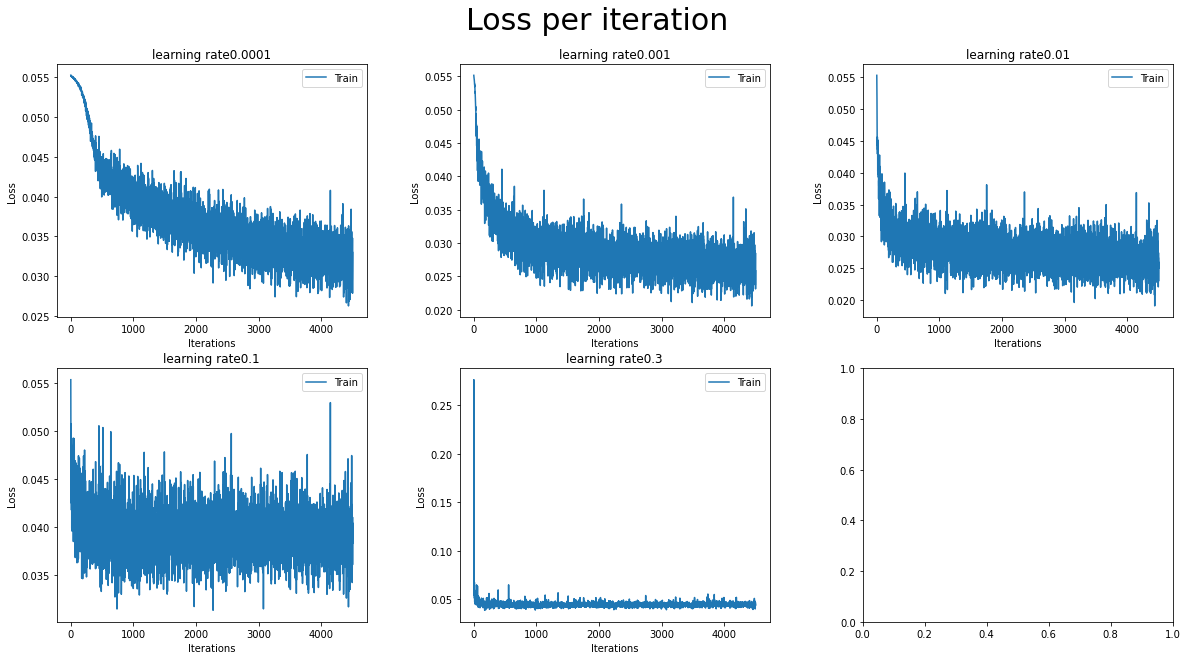

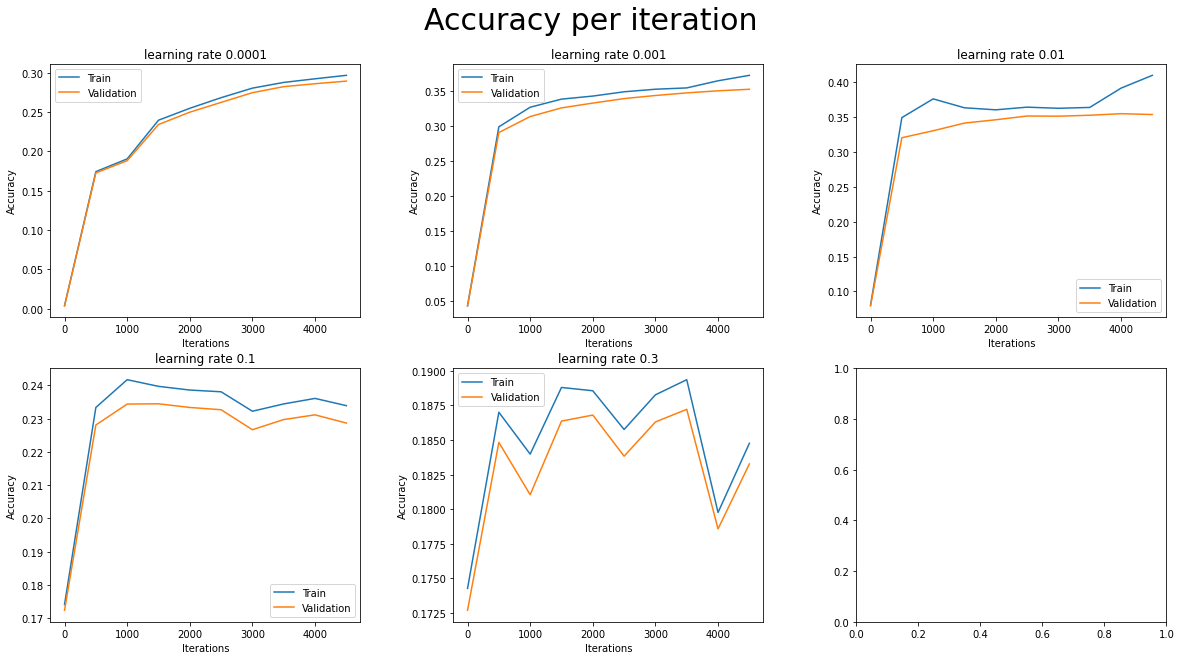

In [ ]:
plot_learning_curve(learning_curve_infos,rows=2,cols=3,parameters=lrs,parameter_name="learning rate")


We observe that using a learning rate of 0.001 achieves the best performance while increasing the learning results in increasing phenomena of oscillations. 

**Batch Size Sweep**
The batch size determines the number of training examples that are used to estimate the gradient of the loss function with respect to the network parameters. Using a large batch size may reduce the noise in the gradient estimation (as can be seen in the figures below), but this will resolve in longer running time.
It is also known that too large a batch size may lead to poor model generalization, as it might be difficult for the model to extract itself from local minima.

In [ ]:
learning_curve_infos=[]
batches=[100,200,300,500,700]
for bs in batches:
  print("batch size",bs)
  pytorch_mlp = PyTorchMLP()
  learning_curve_infos.append(run_pytorch_gradient_descent(pytorch_mlp,
                                                           batch_size=bs,
                                                           max_iters=4500))
  print(50*"=")


batch size 100
Iter 0. [Val Acc 3%] [Train Acc 3%, Loss 5.520562]
Iter 500. [Val Acc 29%] [Train Acc 30%, Loss 2.933729]
Iter 1000. [Val Acc 31%] [Train Acc 33%, Loss 2.707736]
Iter 1500. [Val Acc 33%] [Train Acc 34%, Loss 2.689833]
Iter 2000. [Val Acc 33%] [Train Acc 34%, Loss 2.634876]
Iter 2500. [Val Acc 34%] [Train Acc 35%, Loss 2.627293]
Iter 3000. [Val Acc 34%] [Train Acc 35%, Loss 2.453523]
Iter 3500. [Val Acc 35%] [Train Acc 36%, Loss 2.430391]
Iter 4000. [Val Acc 35%] [Train Acc 36%, Loss 2.599628]
Iter 4500. [Val Acc 35%] [Train Acc 37%, Loss 2.594421]
batch size 200
Iter 0. [Val Acc 1%] [Train Acc 1%, Loss 5.524392]
Iter 500. [Val Acc 31%] [Train Acc 32%, Loss 2.856190]
Iter 1000. [Val Acc 33%] [Train Acc 34%, Loss 2.851133]
Iter 1500. [Val Acc 34%] [Train Acc 35%, Loss 2.713160]
Iter 2000. [Val Acc 34%] [Train Acc 36%, Loss 2.747150]
Iter 2500. [Val Acc 35%] [Train Acc 36%, Loss 2.765647]
Iter 3000. [Val Acc 35%] [Train Acc 37%, Loss 2.765927]
Iter 3500. [Val Acc 36%] [Trai

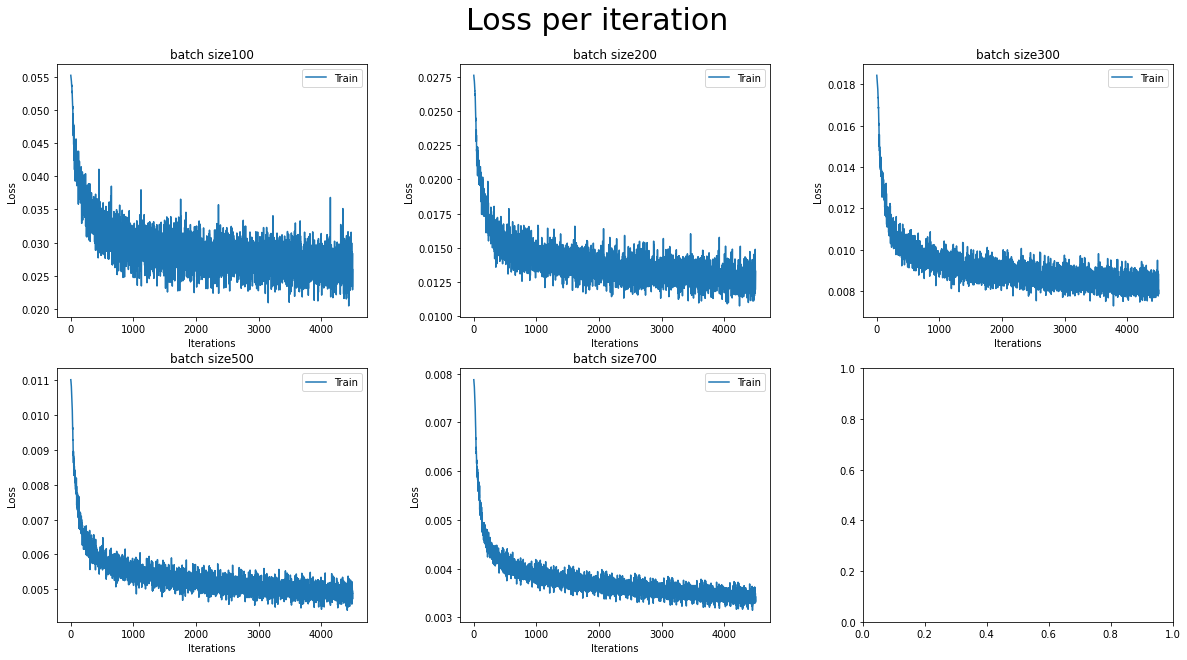

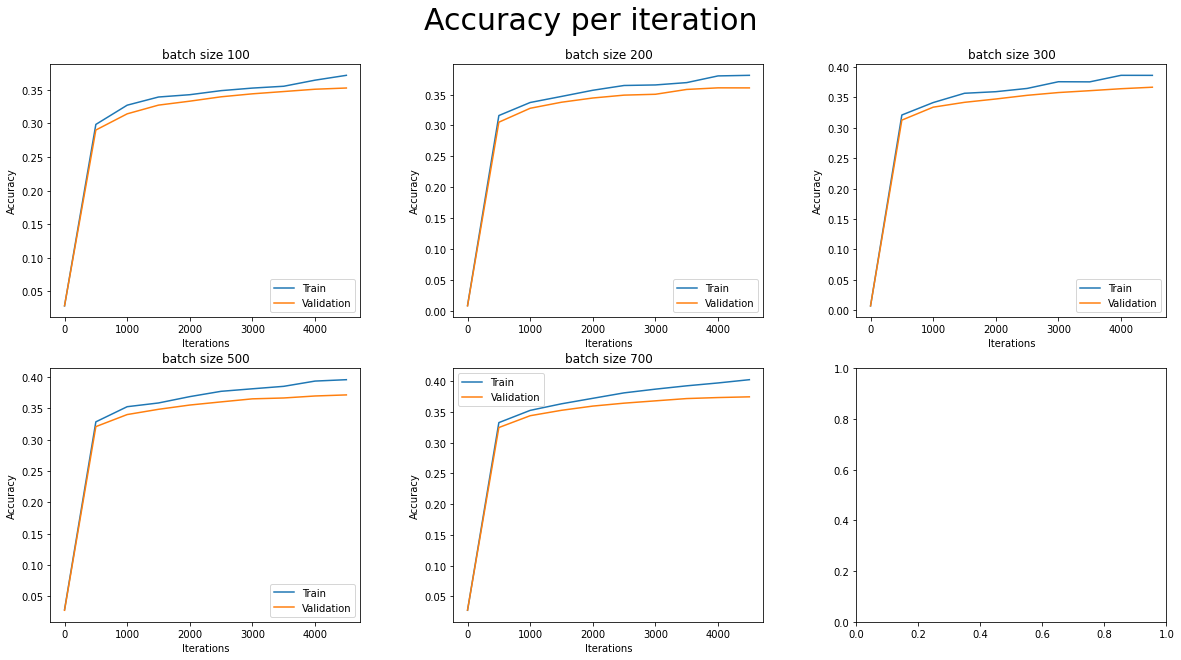

In [ ]:
plot_learning_curve(learning_curve_infos,rows=2,cols=3,parameters=batches,parameter_name="batch size")

We can see that for batch size 500 or 700 the learning curves are smoother and we achieve 37% accuracy over the validation set. We chose batch size 500 because it achieves the same results as for 700 but it can be trained faster.

To avoid the overfitting phenomena, one might choose to change the Loss function in such a way that will penalize the model for larger weights values. By doing so, we change our loss function in the following manner:
$Loss = CrossEntropy(\hat y, y) + w_{decay} * \sum_i w_i^2$
This way, we add the squares values of all the weights to our loss function.
If the constraint on the weights size is stron, this method might significanlty increase our loss. Thus, we introduce the weight decay ($w_{decay}$) hyper-parameter, which multiply the sum of squares values and determine the amount of penalty for large weights.




In [ ]:
learning_curve_infos=[]
wds=[0,0.001]
for wd in wds:
  print("weight decay",wd)
  pytorch_mlp = PyTorchMLP()
  learning_curve_infos.append(run_pytorch_gradient_descent(pytorch_mlp,
                                                           batch_size=500,
                                                           max_iters=4500,
                                                           weight_decay=wd))
  print(50*"=")


weight decay 0
Iter 0. [Val Acc 0%] [Train Acc 0%, Loss 5.523512]
Iter 500. [Val Acc 32%] [Train Acc 33%, Loss 2.863627]
Iter 1000. [Val Acc 34%] [Train Acc 35%, Loss 2.712335]
Iter 1500. [Val Acc 35%] [Train Acc 36%, Loss 2.606374]
Iter 2000. [Val Acc 36%] [Train Acc 37%, Loss 2.606691]
Iter 2500. [Val Acc 36%] [Train Acc 38%, Loss 2.710530]
Iter 3000. [Val Acc 37%] [Train Acc 38%, Loss 2.457216]
Iter 3500. [Val Acc 37%] [Train Acc 39%, Loss 2.385023]
Iter 4000. [Val Acc 37%] [Train Acc 39%, Loss 2.363792]
Iter 4500. [Val Acc 37%] [Train Acc 40%, Loss 2.478756]
weight decay 0.001
Iter 0. [Val Acc 2%] [Train Acc 2%, Loss 5.524007]
Iter 500. [Val Acc 29%] [Train Acc 29%, Loss 3.209248]
Iter 1000. [Val Acc 30%] [Train Acc 30%, Loss 3.122200]
Iter 1500. [Val Acc 30%] [Train Acc 30%, Loss 3.050110]
Iter 2000. [Val Acc 30%] [Train Acc 31%, Loss 3.126995]
Iter 2500. [Val Acc 30%] [Train Acc 31%, Loss 3.300906]
Iter 3000. [Val Acc 30%] [Train Acc 31%, Loss 3.075722]
Iter 3500. [Val Acc 30%] [

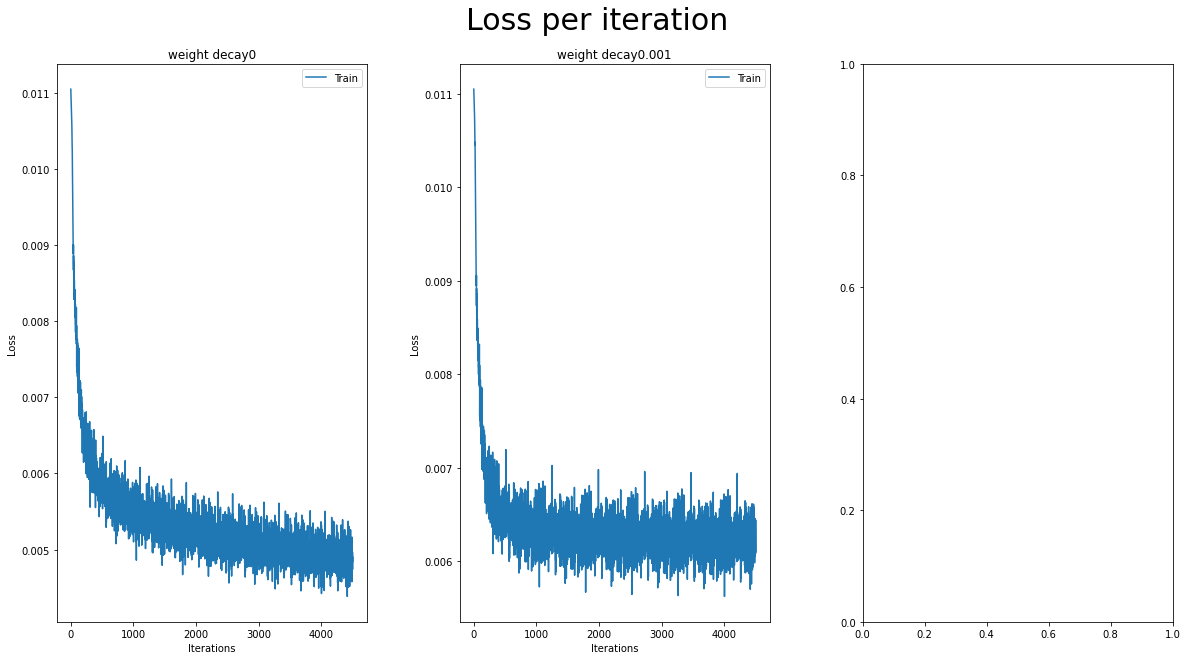

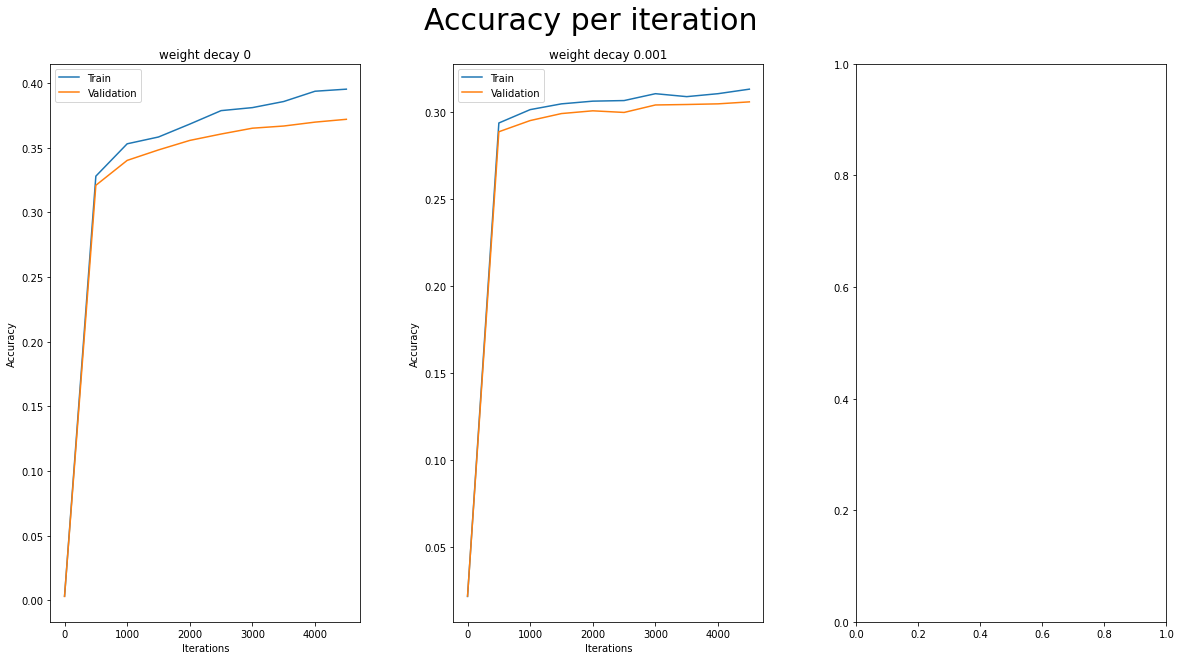

In [ ]:
plot_learning_curve(learning_curve_infos,rows=1,cols=3,parameters=wds,parameter_name="weight decay")

We can see from those results the weight decay 0 achieves the best preformance, which is a reasonable result since we do not observe significant overfitting phenomena over the validation set

In [ ]:
# Choosing best model
pytorch_mlp = PyTorchMLP()
learning_curve_info=run_pytorch_gradient_descent(pytorch_mlp,batch_size=500,
                                                 max_iters=4500,)


Iter 0. [Val Acc 4%] [Train Acc 4%, Loss 5.516104]
Iter 500. [Val Acc 32%] [Train Acc 33%, Loss 2.860423]
Iter 1000. [Val Acc 34%] [Train Acc 35%, Loss 2.714909]
Iter 1500. [Val Acc 35%] [Train Acc 36%, Loss 2.603862]
Iter 2000. [Val Acc 36%] [Train Acc 37%, Loss 2.610183]
Iter 2500. [Val Acc 36%] [Train Acc 38%, Loss 2.699021]
Iter 3000. [Val Acc 36%] [Train Acc 38%, Loss 2.467470]
Iter 3500. [Val Acc 37%] [Train Acc 39%, Loss 2.385092]
Iter 4000. [Val Acc 37%] [Train Acc 39%, Loss 2.360015]
Iter 4500. [Val Acc 37%] [Train Acc 40%, Loss 2.476498]


### Part (c) -- 10%
**Write** a function `make_prediction` that takes as parameters
a PyTorchMLP model and sentence (a list of words), and produces
a prediction for the next word in the sentence.
 

In [ ]:
def make_prediction_torch(model, sentence):
    """
    Use the model to make a prediction for the next word in the
    sentence using the last 3 words (sentence[:-3]). You may assume
    that len(sentence) >= 3 and that `model` is an instance of
    PYTorchMLP.

    This function should return the next word, represented as a string.

    Example call:
    >>> make_prediction_torch(pytorch_mlp, ['you', 'are', 'a'])
    """
    global vocab_stoi, vocab_itos
    sentenceLength = 3
    # Convert the last 3 word to intger representation
    int_sent = convert_words_to_indices([sentence[-3:]])
    # Use one hot encoding
    one_hot_new = make_onehot(int_sent)
    one_hot_sent = torch.tensor(one_hot_new,dtype=torch.float)
    output = model(one_hot_sent).detach().numpy()
    output_integer = np.argmax(output)
    return vocab_itos[output_integer]
  


In [ ]:
make_prediction_torch(pytorch_mlp, ['you', 'are', 'a'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.


'good'

"you are a good" it is a good result in our opinion because it's a reasonable sentence , or more accurate a reasonable prefix for a sentence for exmample : " you are a good boy,girl,teacher,worker,dog,cat and etc.

### Part (d) -- 10%

Use your code to predict what the next word should be in each
of the following sentences:

- "You are a"
- "few companies show"
- "There are no"
- "yesterday i was"
- "the game had"
- "yesterday the federal"

Do your predictions make sense?

In many cases where you overfit the model can either output the same results for all inputs or just memorize the dataset. 

**Print** the output for all of these sentences and 
**Write** below if you encounter these effects or something else which indicates overfitting, if you do train again with better hyperparameters.




In [ ]:
print("1. you are a",make_prediction_torch(pytorch_mlp, ['you', 'are', 'a']))
print("2. few companies shows" , make_prediction_torch(pytorch_mlp,
                                                       ['few', 'companies',
                                                        'show']))
print("3. there are no",make_prediction_torch(pytorch_mlp,
                                              ['there', 'are', 'no']))
print("4. yesterday i was",make_prediction_torch(pytorch_mlp,
                                                 ['yesterday', 'i', 'was']))
print("5. the game had",make_prediction_torch(pytorch_mlp,
                                              ['the', 'game', 'had']))
print("6. yesterday the federal",make_prediction_torch(pytorch_mlp,
                                                       ['yesterday', 'the',
                                                        'federal']))


1. you are a good
2. few companies shows up
3. there are no way
4. yesterday i was nt
5. the game had to
6. yesterday the federal government


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.


1. This is a reasonable sentence.

2. few companies shows up - This is not a reasonable sentence - I would expect to something like - "few companies shows that ...".

3. there are no way - This sentence does not make sense grammatically. Ww would expect to something like, "there are no other"

4. yesterday i was nt - this is not a reasonable result .

5. the game had to - this is a reasonable result because we can say "the game had to end\begin..."

6. yesterday the federal government-this is again, a reasonable result. For example we can say that "yesterday the federal government announced...".


### Part (e) -- 6%

Report the test accuracy of your model

In [ ]:
test_acc = estimate_accuracy_torch(pytorch_mlp, test4grams)
print(f'test accuracy = {test_acc}')

test accuracy = 0.3765160212921407


## Question 3. Learning Word Embeddings (24 %)

In this section, we will build a slightly different model with a different
architecture. In particular, we will first compute a lower-dimensional
*representation* of the three words, before using a multi-layer perceptron.

Our model will look like this:

<img src="https://drive.google.com/uc?id=16lXygLTSuRgOCj6UWK0vHkSoyRJWfMSZ" />
 

This model has 3 layers instead of 2, but the first layer of the network
is **not** fully-connected. Instead, we compute the representations of each
of the three words **separately**. In addition, the first layer of the network
will not use any biases. The reason for this will be clear in question 4.
 

### Part (a) -- 10%

The PyTorch model is implemented for you. Use 
`run_pytorch_gradient_descent` to train
your PyTorch MLP model to obtain a training accuracy of at least 38%.
Plot the learning curve using the `plot_learning_curve` function provided
to you, and include your plot in your PDF submission.


In [ ]:
class PyTorchWordEmb(nn.Module):
    def __init__(self, emb_size=100, num_hidden=300, vocab_size=250):
        super(PyTorchWordEmb, self).__init__()
        self.word_emb_layer = nn.Linear(vocab_size, emb_size, bias=False)
        self.fc_layer1 = nn.Linear(emb_size * 3, num_hidden)
        self.fc_layer2 = nn.Linear(num_hidden, 250)
        self.num_hidden = num_hidden
        self.emb_size = emb_size
    def forward(self, inp):
        embeddings = torch.relu(self.word_emb_layer(inp))
        embeddings = embeddings.reshape([-1, self.emb_size * 3])
        hidden = torch.relu(self.fc_layer1(embeddings))
        return self.fc_layer2(hidden)


We now, perform hyper-parameter tuning for this model.

**Learning Rate sweep**

In [ ]:
learning_curve_infos=[]
lrs=[0.0001,0.001,0.005]
for lr in lrs:
  print("learning rate",lr)
  pytorch_mlp = PyTorchWordEmb()
  learning_curve_infos.append(run_pytorch_gradient_descent(pytorch_mlp,
                                                           learning_rate=lr,
                                                           max_iters=20000,
                                                           batch_size=300))
  print(50*"=")

learning rate 0.0001
Iter 0. [Val Acc 0%] [Train Acc 0%, Loss 5.534619]
Iter 500. [Val Acc 17%] [Train Acc 17%, Loss 4.354609]
Iter 1000. [Val Acc 20%] [Train Acc 20%, Loss 4.044794]
Iter 1500. [Val Acc 24%] [Train Acc 24%, Loss 3.884122]
Iter 2000. [Val Acc 25%] [Train Acc 26%, Loss 3.550960]
Iter 2500. [Val Acc 27%] [Train Acc 27%, Loss 3.371281]
Iter 3000. [Val Acc 27%] [Train Acc 28%, Loss 3.313578]
Iter 3500. [Val Acc 28%] [Train Acc 28%, Loss 3.271270]
Iter 4000. [Val Acc 28%] [Train Acc 29%, Loss 3.370188]
Iter 4500. [Val Acc 29%] [Train Acc 29%, Loss 3.241885]
Iter 5000. [Val Acc 29%] [Train Acc 30%, Loss 3.121267]
Iter 5500. [Val Acc 29%] [Train Acc 30%, Loss 3.064203]
Iter 6000. [Val Acc 30%] [Train Acc 30%, Loss 3.045066]
Iter 6500. [Val Acc 30%] [Train Acc 31%, Loss 2.953429]
Iter 7000. [Val Acc 30%] [Train Acc 31%, Loss 3.040129]
Iter 7500. [Val Acc 30%] [Train Acc 31%, Loss 2.985644]
Iter 8000. [Val Acc 31%] [Train Acc 32%, Loss 3.016756]
Iter 8500. [Val Acc 31%] [Train A

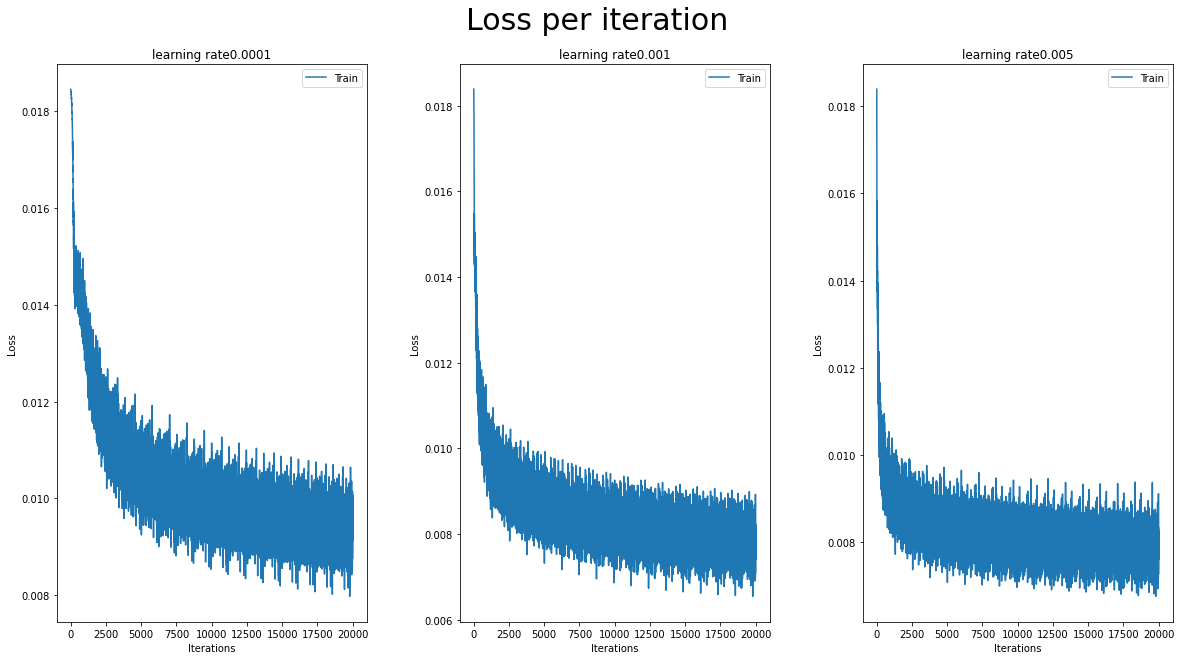

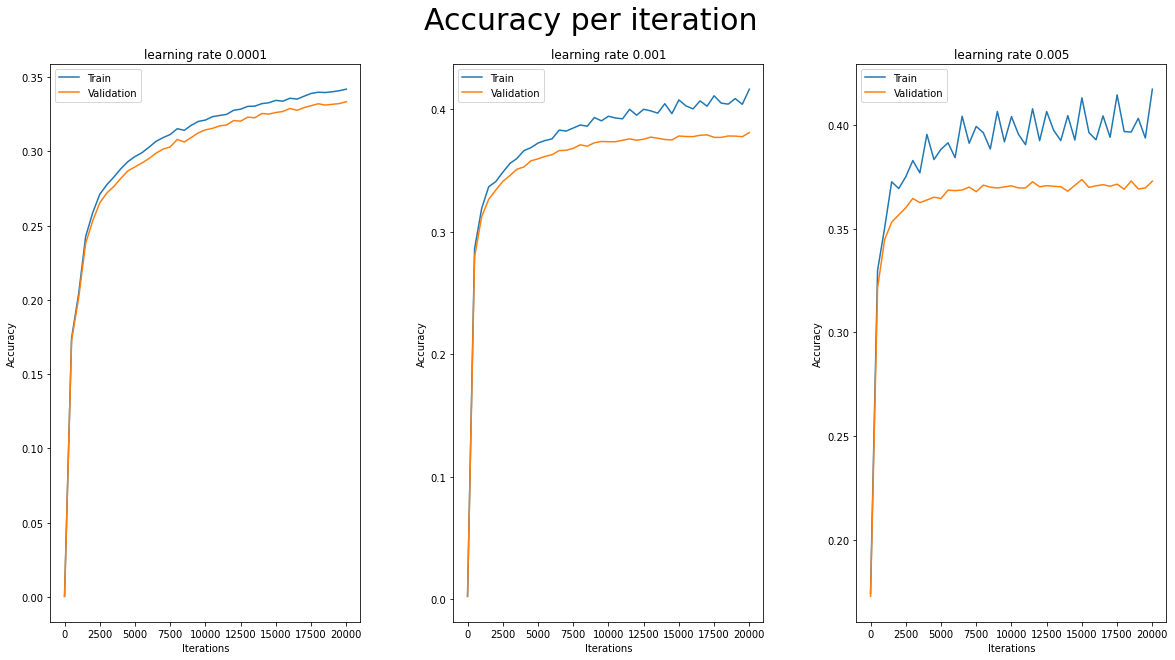

In [ ]:
plot_learning_curve(learning_curve_infos,rows=1,cols=3,parameters=lrs,parameter_name="learning rate")


The best learning rate seems to be 0.001 as it is achieve the best validation accuracy among the tested learning rates.

**Batch size sweep**

In [114]:
learning_curve_infos=[]
batches=[100, 300, 500, 700]
for bs in batches:
  print("batch size",bs)
  pytorch_mlp = PyTorchWordEmb()
  learning_curve_infos.append(run_pytorch_gradient_descent(pytorch_mlp,
                                                           batch_size=bs,
                                                           max_iters=20000))
  print(60*"=")

batch size 100
Iter 0. [Val Acc 1%] [Train Acc 1%, Loss 5.519736]
Iter 500. [Val Acc 27%] [Train Acc 27%, Loss 3.093599]
Iter 1000. [Val Acc 29%] [Train Acc 30%, Loss 2.886434]
Iter 1500. [Val Acc 31%] [Train Acc 31%, Loss 2.807321]
Iter 2000. [Val Acc 32%] [Train Acc 32%, Loss 2.781703]
Iter 2500. [Val Acc 32%] [Train Acc 33%, Loss 2.841236]
Iter 3000. [Val Acc 33%] [Train Acc 34%, Loss 2.568020]
Iter 3500. [Val Acc 33%] [Train Acc 34%, Loss 2.492603]
Iter 4000. [Val Acc 34%] [Train Acc 35%, Loss 2.708815]
Iter 4500. [Val Acc 34%] [Train Acc 35%, Loss 2.756185]
Iter 5000. [Val Acc 35%] [Train Acc 36%, Loss 2.768934]
Iter 5500. [Val Acc 35%] [Train Acc 36%, Loss 2.545349]
Iter 6000. [Val Acc 35%] [Train Acc 36%, Loss 2.737112]
Iter 6500. [Val Acc 35%] [Train Acc 36%, Loss 2.610122]
Iter 7000. [Val Acc 35%] [Train Acc 36%, Loss 2.978507]
Iter 7500. [Val Acc 35%] [Train Acc 36%, Loss 2.772824]
Iter 8000. [Val Acc 36%] [Train Acc 37%, Loss 2.152652]
Iter 8500. [Val Acc 36%] [Train Acc 37%

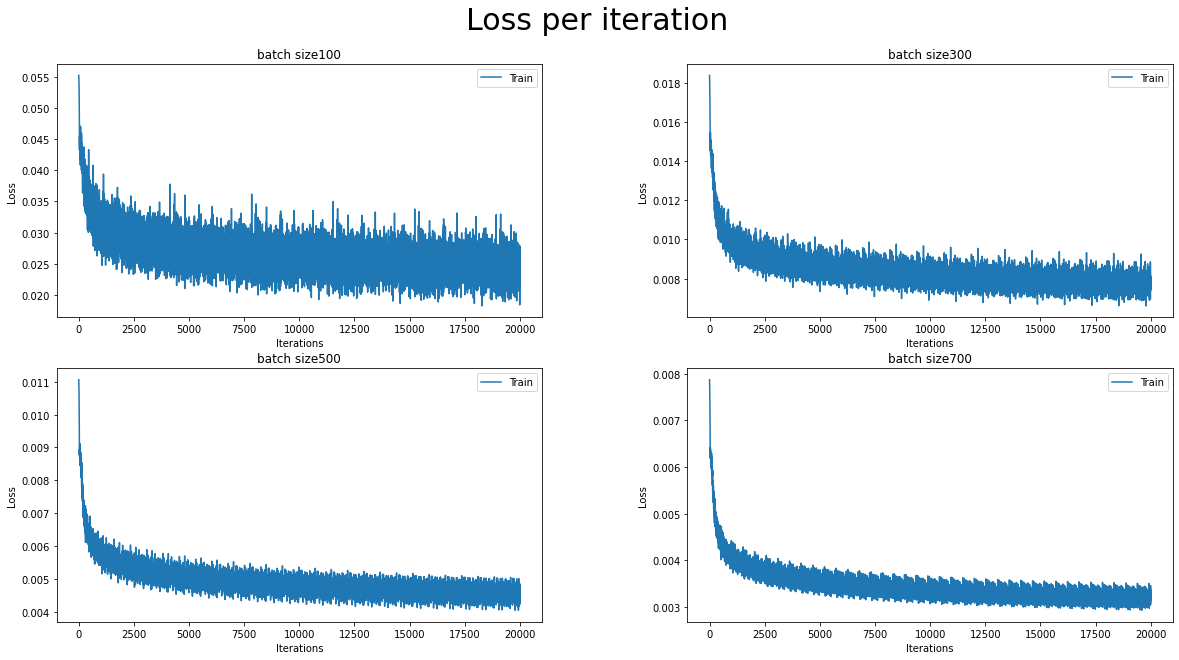

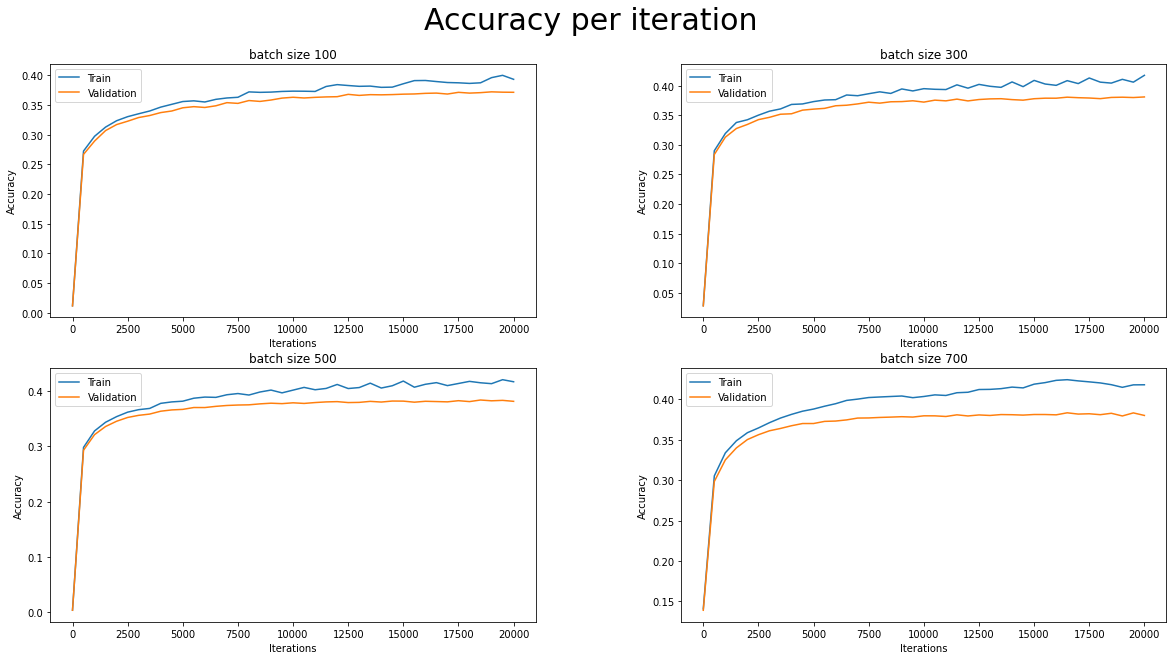

In [115]:
plot_learning_curve(learning_curve_infos,rows=2,cols=2,parameters=batches,
                    parameter_name="batch size")

We can see that for batch sizes 300, 500, and 700 we achieve 38% accuracy over the validation set, but with batch sizes of 500 and 700, the training loss is smaller, thus it might be an indication for the beginning of an overfitting. Thus, we chose the batch size to be 300.

**Weight decay sweep**

In [ ]:
learning_curve_infos=[]
wds=[0,0.001]
for wd in wds:
  print("weight decay",wd)
  pytorch_mlp = PyTorchWordEmb()
  learning_curve_infos.append(run_pytorch_gradient_descent(pytorch_mlp,
                                                           batch_size=300,
                                                           max_iters=20000,
                                                           weight_decay=wd))
  print(50*"=")


weight decay 0
Iter 0. [Val Acc 1%] [Train Acc 1%, Loss 5.529261]
Iter 500. [Val Acc 28%] [Train Acc 29%, Loss 3.207313]
Iter 1000. [Val Acc 31%] [Train Acc 32%, Loss 2.956954]
Iter 1500. [Val Acc 33%] [Train Acc 34%, Loss 2.978416]
Iter 2000. [Val Acc 33%] [Train Acc 34%, Loss 2.786969]
Iter 2500. [Val Acc 34%] [Train Acc 35%, Loss 2.668710]
Iter 3000. [Val Acc 35%] [Train Acc 36%, Loss 2.683311]
Iter 3500. [Val Acc 35%] [Train Acc 36%, Loss 2.637172]
Iter 4000. [Val Acc 35%] [Train Acc 37%, Loss 2.624905]
Iter 4500. [Val Acc 36%] [Train Acc 37%, Loss 2.764373]
Iter 5000. [Val Acc 36%] [Train Acc 37%, Loss 2.613856]
Iter 5500. [Val Acc 36%] [Train Acc 37%, Loss 2.517411]
Iter 6000. [Val Acc 36%] [Train Acc 38%, Loss 2.511677]
Iter 6500. [Val Acc 37%] [Train Acc 38%, Loss 2.561259]
Iter 7000. [Val Acc 37%] [Train Acc 38%, Loss 2.503098]
Iter 7500. [Val Acc 37%] [Train Acc 39%, Loss 2.541619]
Iter 8000. [Val Acc 37%] [Train Acc 39%, Loss 2.620922]
Iter 8500. [Val Acc 37%] [Train Acc 39%

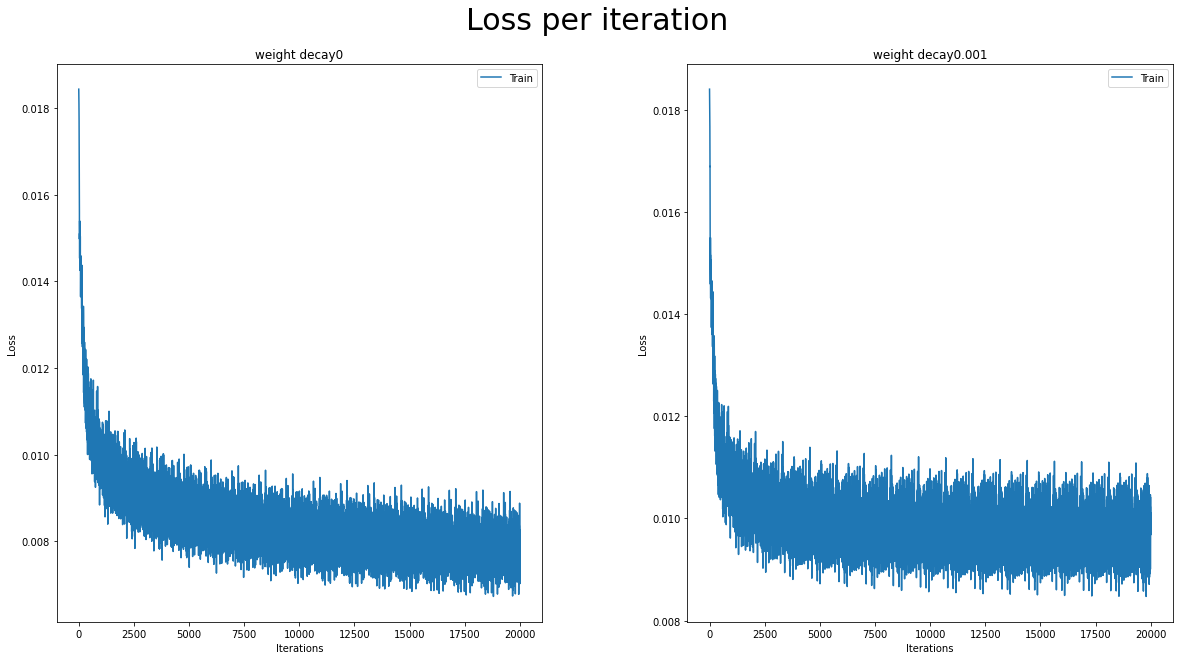

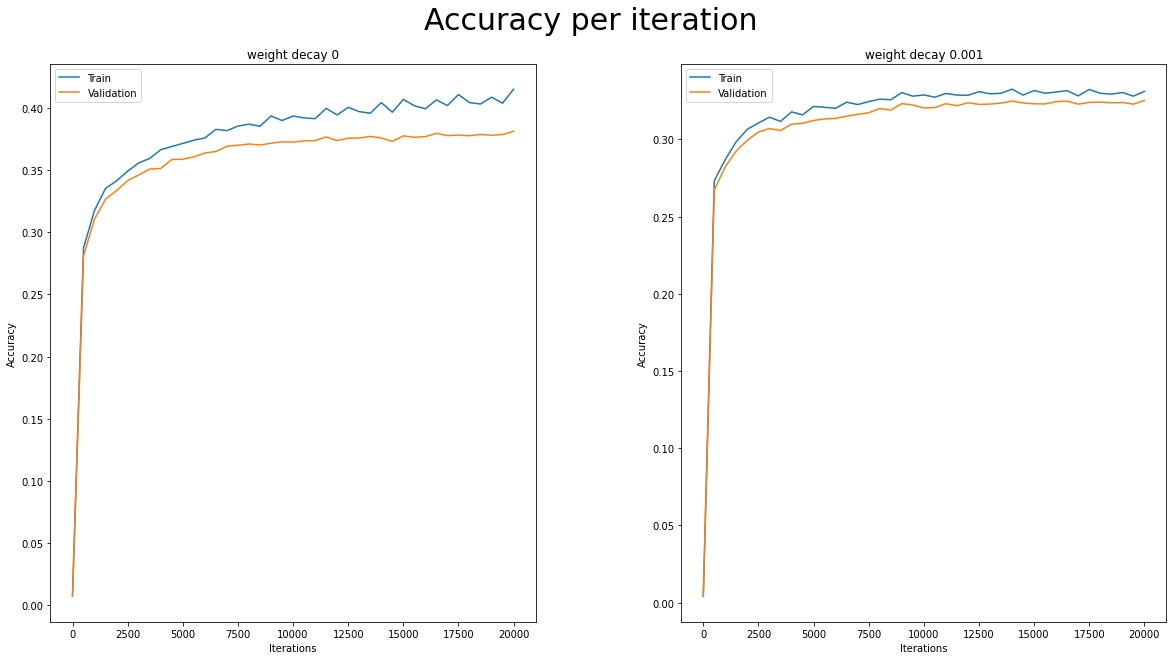

In [ ]:
plot_learning_curve(learning_curve_infos,rows=1,cols=2,parameters=wds,parameter_name="weight decay")

the validation accuracy is much better with no weight decay

In [ ]:
# Choosing best model
pytorch_emb_mlp = PyTorchWordEmb()
learning_curve_info=run_pytorch_gradient_descent(pytorch_emb_mlp,batch_size=300,max_iters=20000)

Iter 0. [Val Acc 0%] [Train Acc 0%, Loss 5.526689]
Iter 500. [Val Acc 28%] [Train Acc 29%, Loss 3.206578]
Iter 1000. [Val Acc 31%] [Train Acc 32%, Loss 2.951108]
Iter 1500. [Val Acc 33%] [Train Acc 33%, Loss 2.944328]
Iter 2000. [Val Acc 33%] [Train Acc 34%, Loss 2.784203]
Iter 2500. [Val Acc 34%] [Train Acc 35%, Loss 2.669496]
Iter 3000. [Val Acc 35%] [Train Acc 36%, Loss 2.668888]
Iter 3500. [Val Acc 35%] [Train Acc 36%, Loss 2.670558]
Iter 4000. [Val Acc 35%] [Train Acc 37%, Loss 2.652486]
Iter 4500. [Val Acc 36%] [Train Acc 37%, Loss 2.762980]
Iter 5000. [Val Acc 36%] [Train Acc 37%, Loss 2.584288]
Iter 5500. [Val Acc 36%] [Train Acc 37%, Loss 2.521867]
Iter 6000. [Val Acc 36%] [Train Acc 38%, Loss 2.531086]
Iter 6500. [Val Acc 37%] [Train Acc 38%, Loss 2.571951]
Iter 7000. [Val Acc 37%] [Train Acc 38%, Loss 2.520452]
Iter 7500. [Val Acc 37%] [Train Acc 39%, Loss 2.574022]
Iter 8000. [Val Acc 37%] [Train Acc 39%, Loss 2.579195]
Iter 8500. [Val Acc 37%] [Train Acc 39%, Loss 2.598128

### Part (b) -- 10%

Use the function `make_prediction` that you wrote earlier to predict what the next word should be in each of the following sentences:

- "You are a"
- "few companies show"
- "There are no"
- "yesterday i was"
- "the game had"
- "yesterday the federal"

How do these predictions compared to the previous model?

**Print** the output for all of these sentences using the new network and 
**Write** below how the new results compare to the previous ones.

Just like before, if you encounter overfitting,
train your model for more iterations, or change the hyperparameters in your
model. You may need to do this even if your training accuracy is >=38%.

In [ ]:
print("1. you are a",make_prediction_torch(pytorch_emb_mlp, ['you', 'are', 'a']))
print("2. few companies shows" , make_prediction_torch(pytorch_emb_mlp, ['few', 'companies', 'show']))
print("3. there are no",make_prediction_torch(pytorch_emb_mlp, ['there', 'are', 'no']))
print("4. yesterday i was",make_prediction_torch(pytorch_emb_mlp, ['yesterday', 'i', 'was']))
print("5. the game had",make_prediction_torch(pytorch_emb_mlp, ['the', 'game', 'had']))
print("6. yesterday the federal",make_prediction_torch(pytorch_emb_mlp, ['yesterday', 'the', 'federal']))

1. you are a good
2. few companies shows it
3. there are no children
4. yesterday i was nt
5. the game had been
6. yesterday the federal government


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.


**Write your explanation here:**
In sentences 1,4,6, we got the same sentences as the previous ones, where all of them make sense except for sentence 4. Sentence 3, was previously "there are no way" which is grammerly incorrect, and now it is "there are no children" which is reasonable. Sentence 2 was previously "few companies shows up" which is not make sense, and now it is "few companies shows it" which is slightly more reasonable according to our opinion. So, the overall results improved over these examples. Sentence 5 was previously "the game had to" and now it is "the game had been" and they are both reasonable.


### Part (c) -- 4%

Report the test accuracy of your model

In [ ]:
# Write your code here
test_acc = estimate_accuracy_torch(pytorch_emb_mlp, test4grams)
print(f'test accuracy = {test_acc}')

test accuracy = 0.3831332846258219


## Question 4. Visualizing Word Embeddings (14%)

While training the `PyTorchMLP`, we trained the `word_emb_layer`, which takes a one-hot
representation of a word in our vocabulary, and returns a low-dimensional vector
representation of that word. In this question, we will explore these word embeddings, which are a key concept in natural language processing.




### Part (a) -- 4%

The code below extracts the **weights** of the word embedding layer,
and converts the PyTorch tensor into an numpy array.
Explain why each *row* of `word_emb` contains the vector representing
of a word. For example `word_emb[vocab_stoi["any"],:]` contains the
vector representation of the word "any".

In [ ]:
word_emb_weights = list(pytorch_emb_mlp.word_emb_layer.parameters())[0]
word_emb = word_emb_weights.detach().numpy().T


**Write your explenation here**

Let $W_{emb}\in\mathbb{R}^{250\times100}$ represent the word_emb matrix.
Each word in the vocabulary represented by a unique one-hot encoded vector.
The i'th word in the vocobulary represented by one-hot encoded vector of size 250, where all the elements are zeros except the i'th element which is 1 (denoted by $onehot(i)$).
Thus, $onehot(i)\cdot W_{emb}$ is the i'th row of the matrix $W_{emb}$.
Hence, we get that the i'th row is the vector that represent the word itself.



### Part (b) -- 5%

One interesting thing about these word embeddings is that distances
in these vector representations of words make some sense! To show this,
we have provided code below that computes the *cosine similarity* of
every pair of words in our vocabulary. This measure of similarity between vector ${\bf v}$ and ${\bf w}$ is defined as 
   $$d_{\rm cos}({\bf v},{\bf w}) = \frac{{\bf v}^T{\bf w}}{||{\bf v}|| ||{\bf w}||}.$$  We also pre-scale the vectors to have a unit norm, using Numpy's `norm` method.

In [ ]:
norms = np.linalg.norm(word_emb, axis=1)
word_emb_norm = (word_emb.T / norms).T
similarities = np.matmul(word_emb_norm, word_emb_norm.T)

# Some example distances. The first one should be larger than the second
print(similarities[vocab_stoi['any'], vocab_stoi['many']])
print(similarities[vocab_stoi['any'], vocab_stoi['government']])

0.20182185
0.108137146


We observe that 'any' is more similar to 'many' than 'government' which makes sense because 'any' and 'many' are kind of quantity measurements.

Compute the 5 closest words to the following words:

- "four"
- "go"
- "what"
- "should"
- "school"
- "your"
- "yesterday"
- "not"

5 closest words to "four": [('three', 0.64701754), ('five', 0.60866493), ('two', 0.5933564), ('those', 0.549723), ('many', 0.42766187)]
5 closest words to "go": [('going', 0.45043024), ('back', 0.41156664), ('public', 0.3627227), ('come', 0.33408493), ('same', 0.33368376)]
5 closest words to "what": [('when', 0.42021105), ('where', 0.418728), ('who', 0.3784999), ('department', 0.3441123), ('world', 0.32364887)]
5 closest words to "should": [('would', 0.5274477), ('can', 0.4505261), ('into', 0.40176833), ('could', 0.40059733), ('may', 0.3431005)]
5 closest words to "school": [('year', 0.39490715), ('time', 0.3914382), ('first', 0.3559972), ('money', 0.35043335), ('states', 0.34001285)]
5 closest words to "your": [('my', 0.8082898), ('his', 0.70943), ('their', 0.42449892), ('ms.', 0.38244393), ('second', 0.3518559)]
5 closest words to "yesterday": [('today', 0.5026515), ('first', 0.44752052), ('him', 0.43063998), (')', 0.3841743), ('family', 0.37628198)]
5 closest words to "not": [('nt',

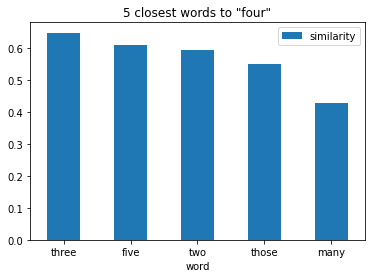

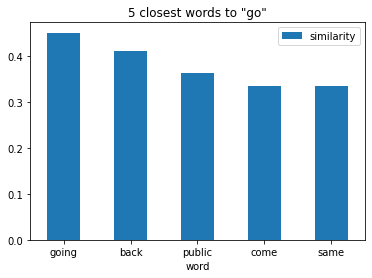

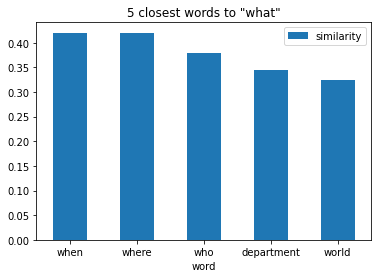

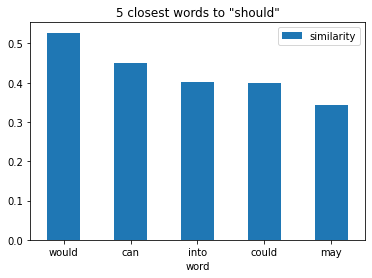

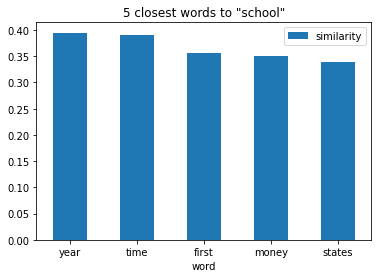

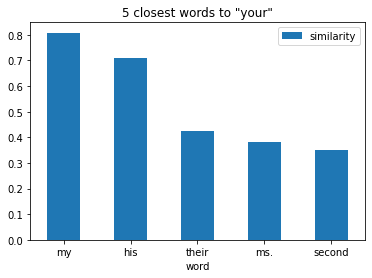

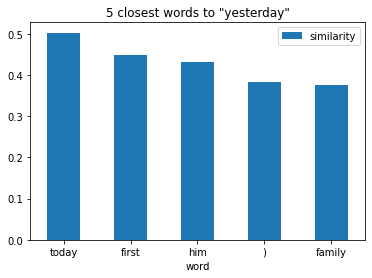

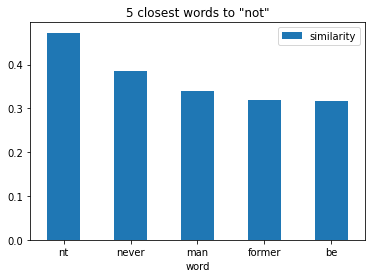

In [ ]:
# Write your code here
list_of_word = ["four","go","what","should","school","your","yesterday","not"]
similarities_dict = {}
for word in list_of_word:
  similarities_vec = similarities[vocab_stoi[word],:]
  most5sim = similarities_vec.argsort()[-6:][::-1][1:]
  similarities_dict[word] = []
  for elem in most5sim:
    similarities_dict[word].append((vocab_itos[elem],similarities_vec[elem]))
  df=pd.DataFrame(similarities_dict[word],columns=['word','similarity'])
  ax=df.plot.bar(x='word', y='similarity', rot=0)
  ax.set_title("5 closest words to \""+word+"\"")
  print("5 closest words to \""+word+"\":",similarities_dict[word])
  print("======================")

In the embedding feature space, we expect that words with closer meaning will have vectors with higher cosine-similarity value. From the above results, we can confirm that this is indeed the case for some cases. For example, when cosidering the word 'four' we found that the closest words in term of cosine-similarity are 'three', 'five', 'two', 'those' and 'many'. Those results are indeed reasonable since we can replace the word 'four' with each one of them and receive a sentence with almost the same meaning. On the other hand, we observe that our algorithm did not perform very well over the word 'school' and the closest words in term of cosine-similarity are 'year', 'time', 'first','money' and 'states'. Those words don't have a very close meaning to the word 'school'. 

### Part (c) -- 5%

We can visualize the word embeddings by reducing the dimensionality of
the word vectors to 2D. There are many dimensionality reduction techniques
that we could use, and we will use an algorithm called t-SNE.
(You don’t need to know what this is for the assignment; we will cover it later in the course.)
Nearby points in this 2-D space are meant to correspond to nearby points
in the original, high-dimensional space.

The following code runs the t-SNE algorithm and plots the result.

Look at the plot and find at least two clusters of related words.

**Write** below for each cluster what is the commonality (if there is any) and if they make sense.

Note that there is randomness in the initialization of the t-SNE 
algorithm. If you re-run this code, you may get a different image.
Please make sure to submit your image in the PDF file.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


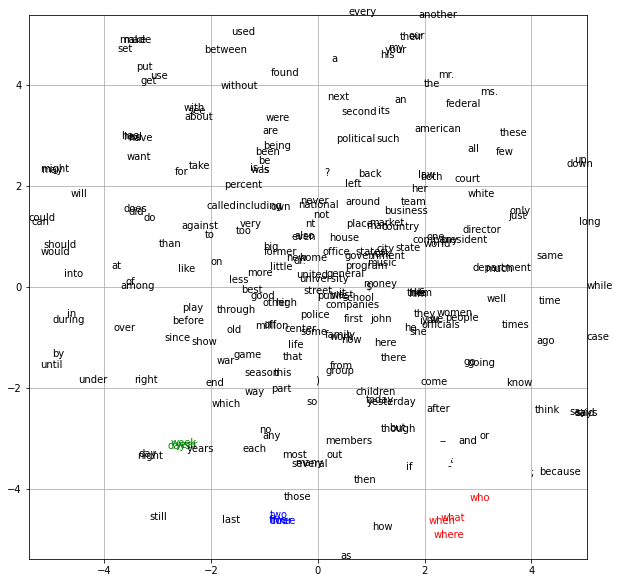

In [99]:
import sklearn.manifold
tsne = sklearn.manifold.TSNE()
Y = tsne.fit_transform(word_emb)

plt.figure(figsize=(10, 10))
plt.xlim(Y[:,0].min(), Y[:, 0].max())
plt.ylim(Y[:,1].min(), Y[:, 1].max())
for i, w in enumerate(vocab):
  if w == 'three' or w=='two' or w=='four'or w=='five':
    plt.text(Y[i, 0], Y[i, 1], w,color='b')
  elif  w=="where"  or w=="who" or w=="what" or w=="when":
    plt.text(Y[i, 0], Y[i, 1], w,color='r')
  elif  w=="year" or w=="week"or w=="days":
    plt.text(Y[i, 0], Y[i, 1], w,color='g')
  else:
    plt.text(Y[i, 0], Y[i, 1], w)
plt.grid()
plt.show()

**Explain and discuss your results here:**
We can see that there is a cluster of the words: "where","when","who","what" (in red). All those words represent a meaning of question, for example 'who sold this car?' or 'what is the time?'.
Moreover, we can observe the blue cluster of "four","three","two","five" which we already wintnessed at the previous question.  Those words have the same meaning of describing something that is not a single object.
In addition the cluster in green contain the words: "year, "days", and "weeks" which represtents time.

**Exporting the code to PDF**

In [101]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
texlive is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
texlive-xetex is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [123]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [124]:
!cp gdrive/My\ Drive/Colab\ Notebooks/Assignment2.ipynb ./

In [125]:
!jupyter nbconvert --to PDF "Assignment2.ipynb"

[NbConvertApp] Converting notebook Assignment2.ipynb to PDF
[NbConvertApp] Support files will be in Assignment2_files/
[NbConvertApp] Making directory ./Assignment2_files
[NbConvertApp] Making directory ./Assignment2_files
[NbConvertApp] Making directory ./Assignment2_files
[NbConvertApp] Making directory ./Assignment2_files
[NbConvertApp] Making directory ./Assignment2_files
[NbConvertApp] Making directory ./Assignment2_files
[NbConvertApp] Making directory ./Assignment2_files
[NbConvertApp] Making directory ./Assignment2_files
[NbConvertApp] Making directory ./Assignment2_files
[NbConvertApp] Making directory ./Assignment2_files
[NbConvertApp] Making directory ./Assignment2_files
[NbConvertApp] Making directory ./Assignment2_files
[NbConvertApp] Making directory ./Assignment2_files
[NbConvertApp] Making directory ./Assignment2_files
[NbConvertApp] Making directory ./Assignment2_files
[NbConvertApp] Making directory ./Assignment2_files
[NbConvertApp] Making directory ./Assignment2_fil